# Reseach Study: Where Did the Nurse Go?
###### Yun Yu

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint
import scipy.stats as ss
from itertools import product

## I. Data Cleanning

#### 1. Basic Cleaning: nulls and standardize categories

In [2]:
qsd = pd.read_csv("qualified.csv")

In [3]:
#1. drop nulls in "is_job_change_since_2019" and "cur_annual_range"
ad = qsd.dropna(subset=["is_job_change_since_2019", "cur_annual_range"]).reset_index(drop=True)
#2. remove unrelated columns
ad = ad.drop(ad.iloc[:, 34:], axis = 1)
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   start_date                         114 non-null    object 
 1   cur_licensed_practical_nurse       2 non-null      object 
 2   cur_registered_nurse               108 non-null    object 
 3   cur_nurse_practitioner             5 non-null      object 
 4   cur_nurse_midwife                  0 non-null      float64
 5   cur_licensed_state                 114 non-null    object 
 6   age_group                          114 non-null    object 
 7   gender                             114 non-null    object 
 8   highest_education                  114 non-null    object 
 9   year_of_first_license              114 non-null    object 
 10  len_of_cur_license_level           114 non-null    object 
 11  was_licensed_nurse_as_of_2019      114 non-null    object 

In [4]:
# after checking the obeservation that has null value in current type of facility, null values will be filled as acute hospital due to none-null value in currrent accute unit.
ad["cur_type_of_facility"].fillna("Acute care hospital", inplace=True)

In [5]:
# check values
for ind, col in enumerate(ad.iloc[:, 0:]):
    print(ind, col, ": ",  ad[col].unique(), "\n")

0 start_date :  ['02/03/2023 09:25:50 AM' '02/02/2023 12:01:38 PM'
 '02/02/2023 11:10:05 AM' '02/02/2023 08:51:20 AM'
 '01/31/2023 06:23:58 PM' '01/31/2023 12:10:03 PM'
 '01/31/2023 10:52:44 AM' '01/30/2023 04:01:36 PM'
 '01/30/2023 03:44:49 PM' '01/30/2023 03:34:07 PM'
 '01/30/2023 02:01:57 PM' '01/30/2023 01:31:25 PM'
 '01/30/2023 01:32:10 PM' '01/30/2023 11:39:33 AM'
 '01/30/2023 10:41:50 AM' '01/30/2023 08:38:59 AM'
 '01/29/2023 11:12:57 PM' '01/29/2023 05:35:47 AM'
 '01/29/2023 05:54:00 AM' '01/28/2023 08:07:28 AM'
 '01/27/2023 02:23:26 PM' '01/27/2023 01:14:35 PM'
 '01/27/2023 08:13:27 AM' '01/27/2023 07:39:34 AM'
 '01/27/2023 07:25:57 AM' '01/27/2023 06:38:54 AM'
 '01/26/2023 08:58:08 PM' '01/26/2023 05:44:09 PM'
 '01/26/2023 04:35:47 PM' '01/26/2023 04:18:54 PM'
 '01/26/2023 03:36:13 PM' '01/26/2023 02:13:29 PM'
 '01/26/2023 02:02:07 PM' '01/26/2023 01:31:10 PM'
 '01/19/2023 10:03:56 AM' '01/19/2023 09:21:06 AM'
 '01/19/2023 08:59:29 AM' '01/18/2023 05:59:29 PM'
 '01/13/2023 10

In [6]:
# categorical
#1. standardize data
## gender
ad["gender"] = ad["gender"].str.upper().apply(lambda x: "Male" if x.startswith("M") else("Female" if x.startswith("F") else ""))
ad["gender"].unique()

array(['Male', 'Female'], dtype=object)

#### 2. Calculated Fields (Derived Variables)

***2-1: Highest Current Practice License***

In [7]:
# get the highest current practice license group
def cur_license_type(clpn, crn, cnp, cnm):
    if pd.notnull(cnp):
        return "Nurse Practitioner"
    elif pd.notnull(cnm):
        return "Nurse Midwife"
    elif pd.notnull(crn) and pd.isnull(cnp) and pd.isnull(cnm):
        return "Registered Nurse"
    else: 
        return "Licensed Practical Nurse"

In [8]:
# calculate highest current practice license
ad["cur_highest_license"] = ad.apply(lambda x: cur_license_type(x["cur_licensed_practical_nurse"], x["cur_registered_nurse"], x["cur_nurse_practitioner"], x["cur_nurse_midwife"]), axis = 1)

***2-2: Total License***

In [9]:
# calculate "total license"
#1. 
ad["clpn"] = ad["cur_licensed_practical_nurse"].copy()
ad["crn"] = ad["cur_registered_nurse"].copy()
ad["cnp"] = ad["cur_nurse_practitioner"].copy()
ad["cnm"] = ad["cur_nurse_midwife"].copy()

#2. assign 0 and 1 to isnull() and notnull()
bi = ["clpn", "crn", "cnp", "cnm"]
for col in bi:
    ad[col] = ad[col].apply(lambda x: 0 if pd.isnull(x) else 1)
#BELOW WHY DIDNT WORK    
#qualified[col] = qualified.loc[qualified[col].isnull(), col] =0
#qualified[col] = qualified.loc[qualified[col].notnull(), col] = 1

#3. calculation
ad["cur_total_license"] = ad[bi].sum(axis=1)

***2-3: Current State License Group***

In [10]:
# assign current license state group 
ad["cur_license_state_group"] = ["One","Compact","Compact","Compact","One","Two","One","One","One","One",
                                 "One","One","Compact","Compact","Compact","One","One","One","One","One",
                                 "One","Compact","One","One","One","One","One","One","One","One",
                                 "One","One","One","One","Compact","One","One","One","One","Three",
                                 "One","One","Three","One","One","One","One","One","Two","Two",
                                 "Two","One","One","Four","Compact","One","One","Compact","One","One",
                                 "One","One","One","Two","One","Compact","Two","One","Three","One",
                                 "Compact","Three","One","One","One","Three","One","Two","One","One",
                                 "Four","One","One","One","Two","Four","One","One","Compact","One",
                                 "One","One","One","One","One","One","One","One","One","One",
                                 "Two","One","One","One","One","One","One","Compact","One","Two",
                                 "Two","One","Three","One"]

***2-4: Years in Profession*** (One NA Droped)

In [11]:
# calculate "years in profession"
#1. convert datetime
ad["start_date"] = pd.to_datetime(ad["start_date"])
#2. replace weired format
ad["year_of_first_license"] = ad["year_of_first_license"].replace(["I was licensed as an RN in 2011 and an LPN in 2004. ", "Minnesota"], [2004, np.nan])
#23. drop nulls and convert "year_of_first_license" to int
ad = ad.dropna(subset=["year_of_first_license"]).reset_index(drop=True)
ad["year_of_first_license"] = ad["year_of_first_license"].astype(int)
#4. calculation
ad["years_in_profession"] = ad["start_date"].dt.year - ad["year_of_first_license"]

***2-5: 2019 Occupation***

In [12]:
# Nurse, Healthcare and None-Healthcare Group
def occupation_2019 (was_nurse, wasin_hc, license_type):
    if was_nurse == "No" and wasin_hc == "No" and pd.isnull(license_type):
        return "None-Healthcare worker"
    elif was_nurse == "No" and wasin_hc == "Yes" and pd.isnull(license_type): 
        return "Healthcare worker"
    else: license_type == license_type
    return license_type

In [13]:
# calculate occupation group in 2019
ad["occupation_asof_2019"] = ad.apply(lambda x: occupation_2019(x["was_licensed_nurse_as_of_2019"], x["was_in_hc_as_of_2019"], x["type_of_license_as_of_2019"]), axis=1)

***2-6: License Level Change Since 2019***

In [14]:
# calculate whether license level changes since 2019
ad["license_type_change_since2019"] = np.where(ad["occupation_asof_2019"] == "Healthcare worker", "Healthcare to Nurse",
                                              np.where(ad["occupation_asof_2019"] == "None-Healthcare worker", "None-Healthcare to Nurse",
                                                      np.where((ad["occupation_asof_2019"] != "Registered nurse") | (ad["cur_total_license"]>1), "Nurse License Changed", "Nurse License the Same")
                                                      )
                                              )

***2-7: Salary Level Change Since 2019***

In [15]:
# calculate whether salary level changed from 2019
#1. asssign ordinal number to salary level in ascending order
sal_level_num = {
    "Less than $55,000": 1,
    "$55,000 to $65,000": 2,
    "$66,000 to $75,000": 3,
    "$76,000 to $85,000": 4,
    "$86,000 to $95,000": 5,
    "$96,000 to $105,000": 6,
    "Greater than $105,000": 7
}
sal_level_col = ["annual_range_as_of_2019", "cur_annual_range"]
ad["2019_sal_level"] = ad[sal_level_col[0]].map(sal_level_num)
ad["cur_sal_level"] = ad[sal_level_col[1]].map(sal_level_num)

#2. convert to int
ad["cur_sal_level"] = ad["cur_sal_level"].astype(int)

#3. calculate
sal_change_conditions = [
    ad["2019_sal_level"]==ad["cur_sal_level"],
    ad["2019_sal_level"]<ad["cur_sal_level"],
    ad["2019_sal_level"]>ad["cur_sal_level"],
]
sal_change_categories = ["No Change", "Level Up", "Level Down"]

ad["change_in_sal_level"] = np.select(sal_change_conditions, sal_change_categories)

***2-8: Job Change Since 2019***

In [16]:
# calculate total job changes
jobs = ["job1", "job2", "job3", "job4"]
ad["total_job_changed_since2019"] = ad[jobs].apply(lambda x: x.count(), axis=1)

In [17]:
# verify calculation
ad[["job1", "job2", "job3", "job4", "total_job_changed_since2019"]]

,job1,job2,job3,job4,total_job_changed_since2019
0,"RN Lutheran ED, left for more money and better...",RN Centura Arvada ED,NaN,NaN,2
1,Director of Nursing & Operations- assisted liv...,"RN COVID Facilitator, occupational health. 1 y...",Clinic RN. 1 year at position. Left because I ...,"PACU RN, 1 year at position. Still employed here.",4
2,"RN, OBGYN Clinic, 5 years in California, moved...","RN, Family Med, current since 6/2022",NaN,NaN,2
3,Med/surg/pediatrics RN 7 years; hired as a ped...,LDRP/postpartum RN current-3 years,NaN,NaN,2
4,RNCM Hospice 3 years change supervisor,RNCM Hospice 7 months cut pay 25%,Vaccinator 3 months Temporary,Clinic RN 18 months currently,4
...,...,...,...,...,...
108,NaN,NaN,NaN,NaN,0
109,NaN,NaN,NaN,NaN,0
110,NaN,NaN,NaN,NaN,0
111,NaN,NaN,NaN,NaN,0


***2-9 Facility As of 2019 & Current***

In [18]:
# calculate whether was in acute hospital
ad["facility_2019"] = np.where(ad["type_of_facility_as_of_2019"]=="Acute care hospital", "Acute Care Hospital", "None-Acute Care Facility")

# calcute whether cur in acute hospital
ad["facility_cur"] = np.where(ad["cur_type_of_facility"]=="Acute care hospital", "Acute Care Hospital", "None-Acute Care Facility")

***2-10: Acute Unit As of 2019 & Current***

In [19]:
# Acute Facility Unit Group
def unit_group(unit_type):
    if unit_type == "Medical/surgical" or unit_type == "Surgical services":
        return "Surgical"
    elif unit_type == "OB / Women and Infants (including mother / baby or postpartum)" or unit_type == "Neonatal critical care": 
        return "OB-GYN"
    elif unit_type == "Pediatrics" or unit_type == "Pediatric critical care":
        return "Ped"
    elif unit_type == "Not in direct patient care (i.e. education, research, management/leadership, care management, informatics, etc.)":
        return "Administrative"
    elif unit_type == "Other:Please enter your unit or department in the space below.":
        return "Other Acute Hospital Based"
    elif pd.isnull(unit_type):
        return "None-Acute Care Facility"
    else: 
        return unit_type

In [20]:
# calculate whether was in hospital acute unit
ad["unit_2019"] = ad.apply(lambda x: unit_group(x["acute_unit_as_of_2019"]), axis=1)

# calculate whether cur in hospital acute unit
ad["unit_cur"] = ad.apply(lambda x: unit_group(x["cur_acute_unit"]), axis=1)

In [21]:
# fix error
ad["unit_2019"] = np.where(
   (ad["facility_2019"]=="None-Acute Care Facility") & (ad["unit_2019"]=="Administrative") , "None-Acute Care Facility", ad["unit_2019"]
   )

In [22]:
ad["facility_2019"].unique()

array(['None-Acute Care Facility', 'Acute Care Hospital'], dtype=object)

***2-11: Is Facility Changed & Is Unit Changed***

In [23]:
# comparison function
def is_changed(old, new):
    if old == new:
        return "No Change"
    else:
        return "Changed"

In [24]:
# calculate whether facility type changed
ad["facility_change"] = ad.apply(lambda x: is_changed(x["facility_2019"], x["facility_cur"]), axis=1)

# calculate whether unit type changed
ad["unit_change"] = ad.apply(lambda x: is_changed(x["unit_2019"], x["unit_cur"]), axis=1)

***2-12: Concat Facility - Unit 2019 & Concat Facility - Unit Current***

In [25]:
# group facility - unit 2019
ad["facility_unit_2019"] = ad["facility_2019"] + " - " + ad["unit_2019"]
ad["facility_unit_cur"] = ad["facility_cur"] + " - " + ad["unit_cur"]

***2-13: Is Facility - Unit Changed***

In [26]:
# calculate whether facility type - unit type changed
ad["facility-unit_change"] = ad.apply(lambda x: is_changed(x["facility_unit_2019"], x["facility_unit_cur"]), axis=1)

***2-14: Years in Profession Bin***

In [27]:
# find bin value for years in profession
# create years in profession category
yrp_min = ad["years_in_profession"].min()
yrp_max = ad["years_in_profession"].max()
bins = np.linspace(yrp_min, yrp_max, 10)
bins

# qcut
qc = pd.qcut(ad["years_in_profession"], q=10)
qc.value_counts()
# cut 
c = pd.cut(ad["years_in_profession"], bins=10)
c.value_counts()

(5.5, 10.0]     24
(14.5, 19.0]    21
(0.955, 5.5]    21
(10.0, 14.5]    13
(23.5, 28.0]    11
(19.0, 23.5]     9
(28.0, 32.5]     5
(37.0, 41.5]     4
(32.5, 37.0]     3
(41.5, 46.0]     2
Name: years_in_profession, dtype: int64

In [28]:
# create custom years in profession category/bin (not using the bin method above)
years_in_profession_conditions = [
    ad["years_in_profession"] == 0,
    ad["years_in_profession"] <= 3,
    ad["years_in_profession"] <= 5,
    ad["years_in_profession"] <= 10,
    ad["years_in_profession"] <= 15,
    ad["years_in_profession"] <= 20,
    ad["years_in_profession"] <= 30,
    ad["years_in_profession"] >30
]

years_in_profession_categories = ["less than a year", "1-3 year", "4-5 year", "6-10 year", "11-15 year", "16-20 year", "21-30 year", "greater than 30 years"]

ad["years_in_profession_cat"] = np.select(years_in_profession_conditions, years_in_profession_categories)

In [29]:
# assign years in profession category with numbers in ascending order
years_profession_cat_order = {
    "less than a year": 0, 
    "1-3 year": 1, 
    "4-5 year": 2, 
    "6-10 year": 3, 
    "11-15 year": 4, 
    "16-20 year": 5, 
    "21-30 year": 6, 
    "greater than 30 years": 7
}

ad["years_in_profession_cat_num"] = ad["years_in_profession_cat"].map(years_profession_cat_order)

#### 3. Select Analysis Data

In [30]:
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 59 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   start_date                         113 non-null    datetime64[ns]
 1   cur_licensed_practical_nurse       2 non-null      object        
 2   cur_registered_nurse               107 non-null    object        
 3   cur_nurse_practitioner             5 non-null      object        
 4   cur_nurse_midwife                  0 non-null      float64       
 5   cur_licensed_state                 113 non-null    object        
 6   age_group                          113 non-null    object        
 7   gender                             113 non-null    object        
 8   highest_education                  113 non-null    object        
 9   year_of_first_license              113 non-null    int64         
 10  len_of_cur_license_level           113

In [31]:
cleaned_dt = ad.iloc[:, [6,7,8,10,27,28,29,34,39,40,41,42,43,46,47,48,49,50,51,52,53,54,55,56,57,58]]
cleaned_dt

,age_group,gender,highest_education,len_of_cur_license_level,annual_range_as_of_2019,cur_annual_range,is_job_change_since_2019,cur_highest_license,cur_total_license,cur_license_state_group,...,facility_cur,unit_2019,unit_cur,facility_change,unit_change,facility_unit_2019,facility_unit_cur,facility-unit_change,years_in_profession_cat,years_in_profession_cat_num
0,35-44,Male,Bachelor's Degree,3 to 5 years,"Less than $55,000","$86,000 to $95,000",Yes,Registered Nurse,1,One,...,None-Acute Care Facility,None-Acute Care Facility,None-Acute Care Facility,No Change,No Change,None-Acute Care Facility - None-Acute Care Fac...,None-Acute Care Facility - None-Acute Care Fac...,No Change,4-5 year,2
1,35-44,Female,Master's Degree,1 to 2 years,"Less than $55,000","$76,000 to $85,000",Yes,Registered Nurse,1,Compact,...,Acute Care Hospital,None-Acute Care Facility,Surgical,Changed,Changed,None-Acute Care Facility - None-Acute Care Fac...,Acute Care Hospital - Surgical,Changed,16-20 year,5
2,35-44,Female,Associate Degree,11 to 20 years,"Greater than $105,000","$96,000 to $105,000",Yes,Registered Nurse,1,Compact,...,None-Acute Care Facility,None-Acute Care Facility,None-Acute Care Facility,No Change,No Change,None-Acute Care Facility - None-Acute Care Fac...,None-Acute Care Facility - None-Acute Care Fac...,No Change,11-15 year,4
3,45-54,Female,Bachelor's Degree,11 to 20 years,"Less than $55,000","$55,000 to $65,000",Yes,Registered Nurse,1,Compact,...,Acute Care Hospital,Surgical,OB-GYN,No Change,Changed,Acute Care Hospital - Surgical,Acute Care Hospital - OB-GYN,Changed,16-20 year,5
4,65+,Female,Associate Degree,21 to 30 years,"$55,000 to $65,000","$86,000 to $95,000",Yes,Registered Nurse,1,One,...,None-Acute Care Facility,None-Acute Care Facility,None-Acute Care Facility,No Change,No Change,None-Acute Care Facility - None-Acute Care Fac...,None-Acute Care Facility - None-Acute Care Fac...,No Change,21-30 year,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,25-34,Female,Associate Degree,11 to 20 years,"$55,000 to $65,000","$55,000 to $65,000",No,Licensed Practical Nurse,1,Two,...,Acute Care Hospital,Surgical,Surgical,No Change,No Change,Acute Care Hospital - Surgical,Acute Care Hospital - Surgical,No Change,11-15 year,4
109,25-34,Female,Bachelor's Degree,6 to 10 years,"$66,000 to $75,000","$66,000 to $75,000",No,Registered Nurse,1,Two,...,Acute Care Hospital,Surgical,Surgical,No Change,No Change,Acute Care Hospital - Surgical,Acute Care Hospital - Surgical,No Change,6-10 year,3
110,35-44,Female,Bachelor's Degree,11 to 20 years,"$76,000 to $85,000","$76,000 to $85,000",No,Registered Nurse,1,One,...,Acute Care Hospital,Surgical,Critical care,No Change,Changed,Acute Care Hospital - Surgical,Acute Care Hospital - Critical care,Changed,16-20 year,5
111,45-54,Female,Clinical Doctorate,3 to 5 years,"$96,000 to $105,000","$96,000 to $105,000",No,Nurse Practitioner,1,Three,...,None-Acute Care Facility,None-Acute Care Facility,None-Acute Care Facility,No Change,No Change,None-Acute Care Facility - None-Acute Care Fac...,None-Acute Care Facility - None-Acute Care Fac...,No Change,21-30 year,6


In [32]:
# delete rows Job Changes "Yes", but 0 jobs
cleaned_dt = cleaned_dt.loc[~( (cleaned_dt["is_job_change_since_2019"]=="Yes") & (cleaned_dt["total_job_changed_since2019"]==0) )]

In [33]:
# change data type
cont_list = ["cur_total_license", "years_in_profession", "total_job_changed_since2019"]
for col in cleaned_dt.columns:
    if col not in cont_list:
        cleaned_dt[col] = cleaned_dt[col].astype("category")

<ipython-input-33-f74b9d3acdbb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dt[col] = cleaned_dt[col].astype("category")


In [34]:
for ind, col in enumerate(cleaned_dt):
    print(ind, col, ": ",  ad[col].nunique(), "\n")

0 age_group :  6 

1 gender :  2 

2 highest_education :  6 

3 len_of_cur_license_level :  6 

4 annual_range_as_of_2019 :  7 

5 cur_annual_range :  7 

6 is_job_change_since_2019 :  2 

7 cur_highest_license :  3 

8 cur_total_license :  2 

9 cur_license_state_group :  5 

10 years_in_profession :  37 

11 occupation_asof_2019 :  5 

12 license_type_change_since2019 :  4 

13 change_in_sal_level :  3 

14 total_job_changed_since2019 :  5 

15 facility_2019 :  2 

16 facility_cur :  2 

17 unit_2019 :  8 

18 unit_cur :  8 

19 facility_change :  2 

20 unit_change :  2 

21 facility_unit_2019 :  8 

22 facility_unit_cur :  8 

23 facility-unit_change :  2 

24 years_in_profession_cat :  7 

25 years_in_profession_cat_num :  7 



In [35]:
df = cleaned_dt
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 0 to 112
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age_group                      111 non-null    category
 1   gender                         111 non-null    category
 2   highest_education              111 non-null    category
 3   len_of_cur_license_level       111 non-null    category
 4   annual_range_as_of_2019        111 non-null    category
 5   cur_annual_range               111 non-null    category
 6   is_job_change_since_2019       111 non-null    category
 7   cur_highest_license            111 non-null    category
 8   cur_total_license              111 non-null    int64   
 9   cur_license_state_group        111 non-null    category
 10  years_in_profession            111 non-null    int64   
 11  occupation_asof_2019           111 non-null    category
 12  license_type_change_since2019  111 n

## III. Analysis

## 3.1 Descriptive

In [36]:
# sperate cont and cat variables
cat_list = [c for c in df.columns if c not in cont_list]
cat_df = df.drop(cont_list, axis=1)
cont_df = df.drop(cat_list, axis=1)

In [37]:
# get all cont variable basic description
cont_df.describe()

,cur_total_license,years_in_profession,total_job_changed_since2019
count,111.000000,111.000000,111.000000
mean,1.009009,15.441441,1.612613
std,0.094916,10.613614,1.408876
min,1.000000,1.000000,0.000000
25%,1.000000,7.000000,0.000000
50%,1.000000,14.000000,2.000000
75%,1.000000,21.000000,3.000000
max,2.000000,46.000000,4.000000


In [38]:
# get all cat variables basic description
for col in cat_df.columns:
    print(cat_df[col].value_counts(), "\n", col, " has a Total of ", len(cat_df[col].unique()), " Unique Values", "\n\n", )

25-34    31
35-44    29
45-54    22
55-64    18
18-24     6
65+       5
Name: age_group, dtype: int64 
 age_group  has a Total of  6  Unique Values 


Female    101
Male       10
Name: gender, dtype: int64 
 gender  has a Total of  2  Unique Values 


Bachelor's Degree     70
Master's Degree       28
Associate Degree       6
Clinical Doctorate     4
PhD                    2
Diploma Nurse          1
Name: highest_education, dtype: int64 
 highest_education  has a Total of  6  Unique Values 


11 to 20 years           37
6 to 10 years            19
21 to 30 years           18
3 to 5 years             15
1 to 2 years             14
Greater than 30 years     8
Name: len_of_cur_license_level, dtype: int64 
 len_of_cur_license_level  has a Total of  6  Unique Values 


$66,000 to $75,000       21
$55,000 to $65,000       19
Less than $55,000        18
$86,000 to $95,000       17
Greater than $105,000    16
$76,000 to $85,000       13
$96,000 to $105,000       7
Name: annual_range_as_of_2019,

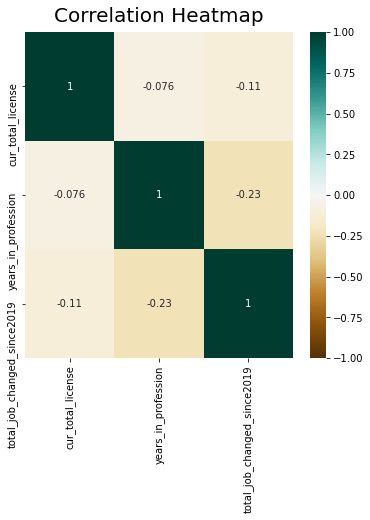

In [39]:
# correlation plot with ONLY continous variables
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(cont_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=10);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
# save picture
#plt.savefig('heatmap.png', dpi=1080, bbox_inches='tight')

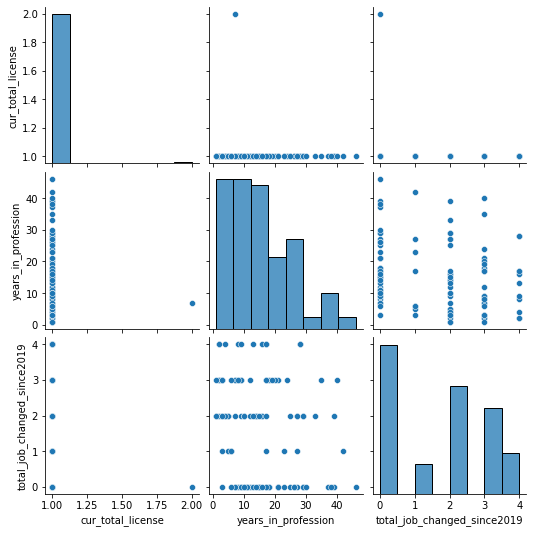

In [40]:
# pairplot 
sns.pairplot(cont_df#, kind="hist"
            )

<Axes: xlabel='is_job_change_since_2019', ylabel='years_in_profession'>

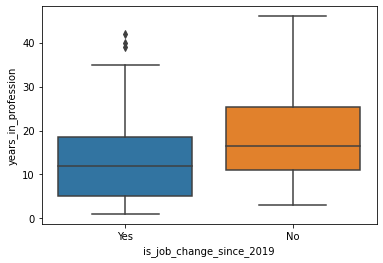

In [41]:
# years in profession boxplot
sns.boxplot(data=df, y="years_in_profession", x="is_job_change_since_2019", order=["Yes", "No"])

## 3.2: EDA

### 3.2.1 Basic EDA

In [42]:
palette ={"Yes": "C1", "No": "C0"}
palette1 ={"Level Up": "C1", "Level Down": "C0", "No Change": "C2"}

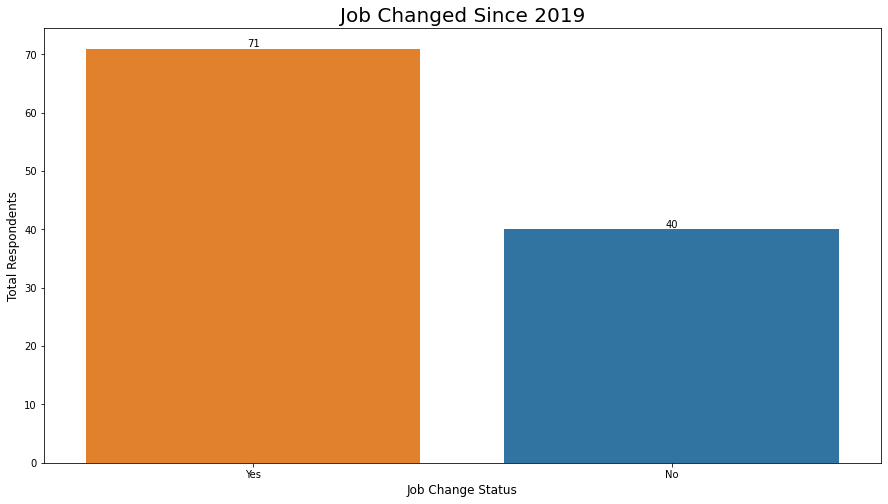

In [43]:
# Job Change Status
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="is_job_change_since_2019", order=["Yes", "No"], palette=palette)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019" , size = 20 )
plt.xlabel( "Job Change Status" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("1.jpg")
plt.show()

***Age Group***

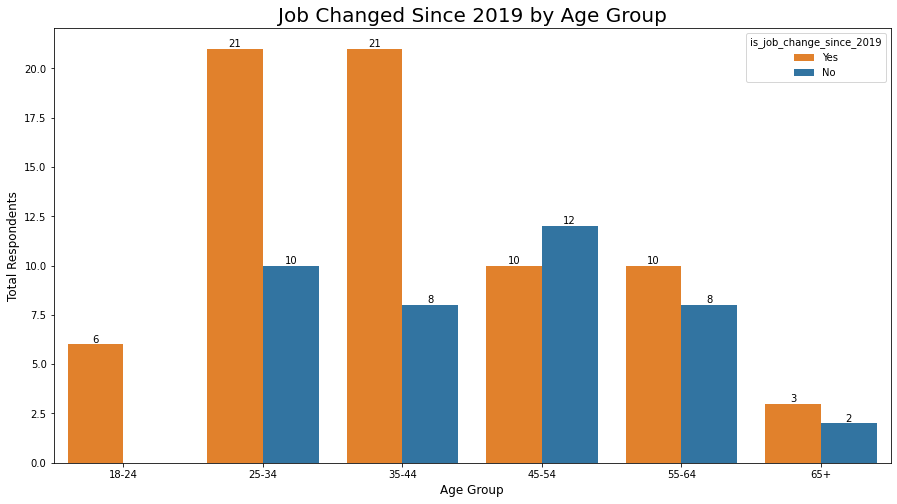

In [44]:
# age group vs job change
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="age_group", hue="is_job_change_since_2019", hue_order=["Yes", "No"], palette=palette)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019 by Age Group" , size = 20 )
plt.xlabel( "Age Group" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("2.jpg")
plt.show()

***Education Level***

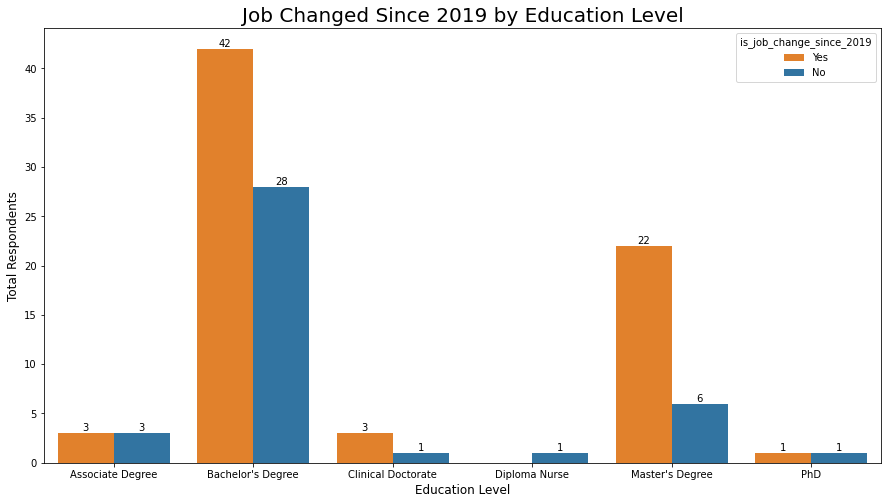

In [45]:
# highest education vs job change
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="highest_education", hue="is_job_change_since_2019", hue_order=["Yes", "No"], palette=palette)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019 by Education Level" , size = 20 )
plt.xlabel( "Education Level" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("3.jpg")
plt.show()

***Gender***

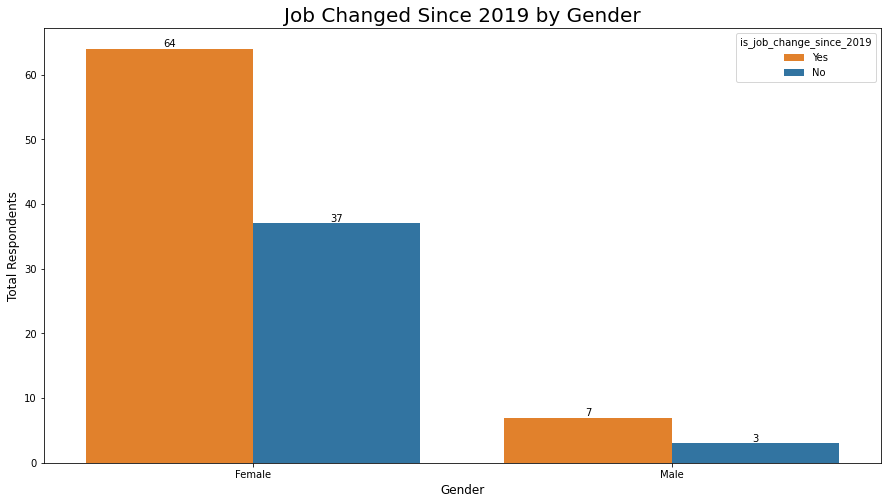

In [46]:
# gender vs job change
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="gender", hue="is_job_change_since_2019", hue_order=["Yes", "No"], palette=palette)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019 by Gender" , size = 20 )
plt.xlabel( "Gender" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("4.jpg")
plt.show()

***Current License State Group***

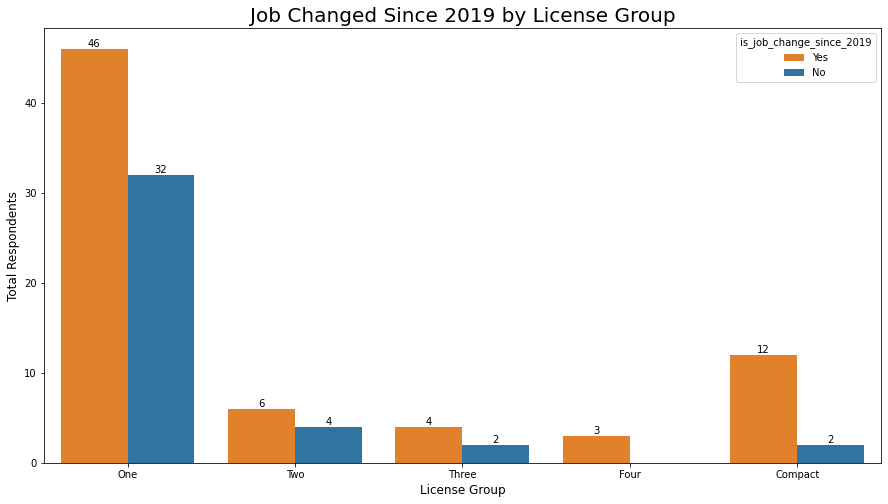

In [47]:
# cur_license_state_group vs job change
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="cur_license_state_group", hue="is_job_change_since_2019", order=["One", "Two", "Three", "Four", "Compact"], 
              hue_order=["Yes", "No"], palette=palette)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019 by License Group" , size = 20 )
plt.xlabel( "License Group" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("5.jpg")
plt.show()

***License Type Change***

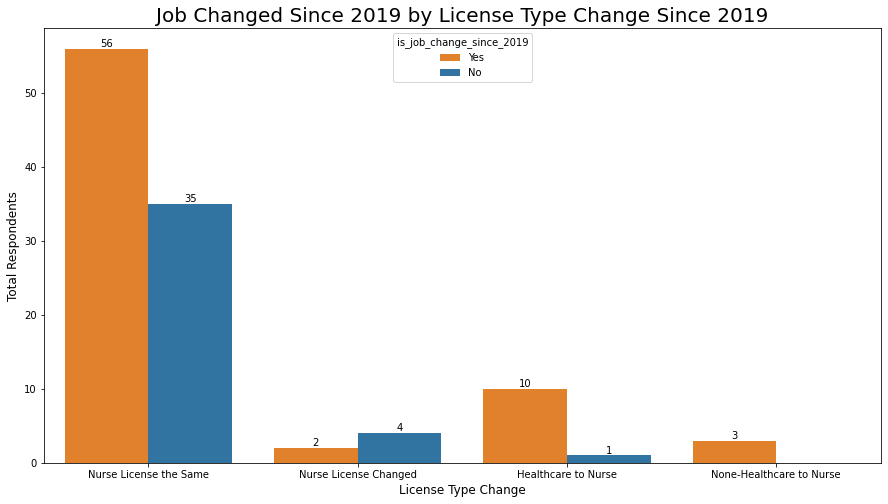

In [48]:
# license_type_change_since2019 vs job change
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="license_type_change_since2019", hue="is_job_change_since_2019", order=["Nurse License the Same", "Nurse License Changed", "Healthcare to Nurse", "None-Healthcare to Nurse"],
              hue_order=["Yes", "No"], palette=palette)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019 by License Type Change Since 2019" , size = 20 )
plt.xlabel( "License Type Change" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("6.jpg")
plt.show()

***Years in Profession***

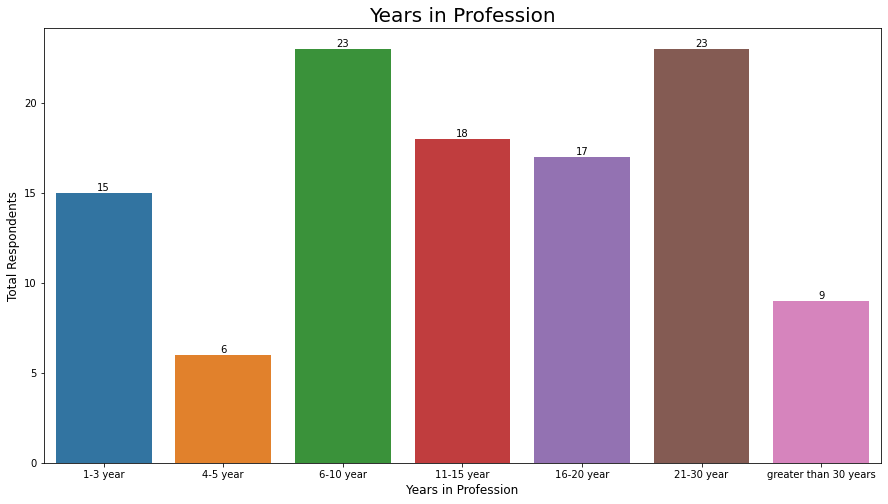

In [49]:
# plot years in profession category
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="years_in_profession_cat", order=["1-3 year", "4-5 year", "6-10 year", "11-15 year", "16-20 year", "21-30 year", "greater than 30 years"])
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Years in Profession" , size = 20 )
plt.xlabel( "Years in Profession" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("7.jpg")
plt.show()

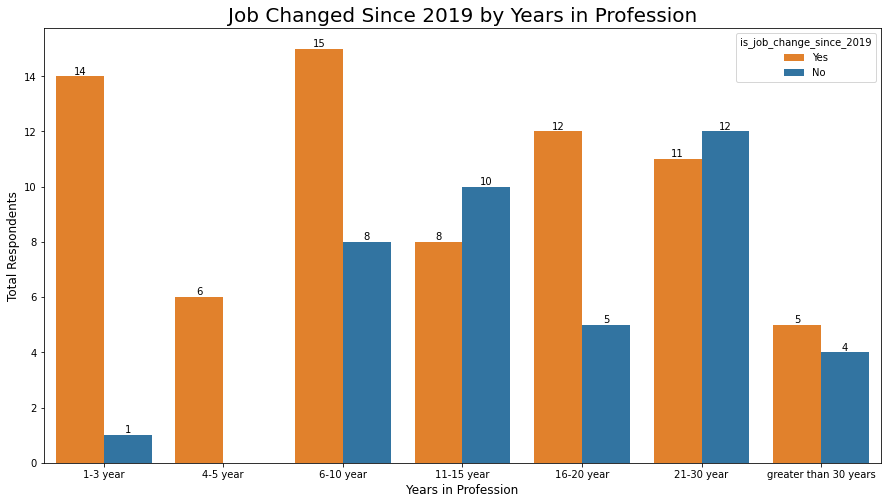

In [50]:
# years_in_profession_cat vs job change
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="years_in_profession_cat", hue="is_job_change_since_2019", order=["1-3 year", "4-5 year", "6-10 year", "11-15 year", "16-20 year", "21-30 year", "greater than 30 years"],
              hue_order=["Yes", "No"], palette=palette)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019 by Years in Profession" , size = 20 )
plt.xlabel( "Years in Profession" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("8.jpg")
plt.show()

***Changes in Salary Level***

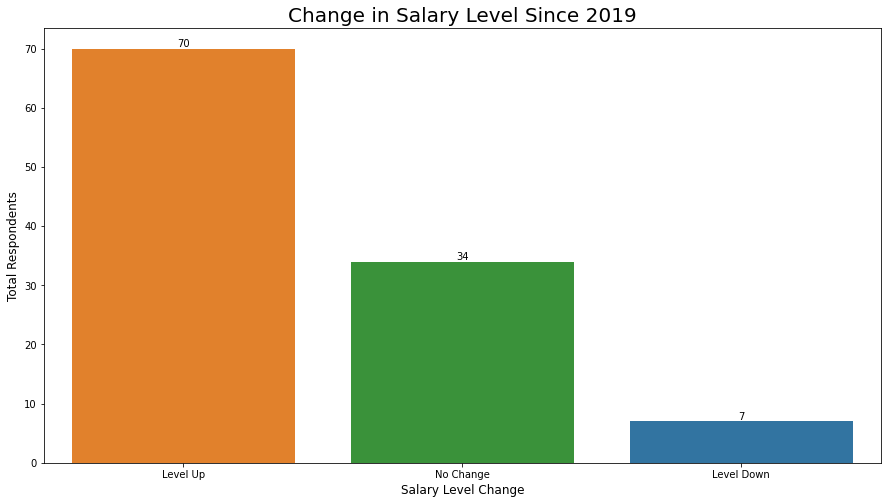

In [103]:
#change_in_sal_level
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="change_in_sal_level", order=["Level Up", "No Change", "Level Down"], palette=palette1)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Change in Salary Level Since 2019", size = 20 )
plt.xlabel( "Salary Level Change" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("9.jpg")
plt.show()

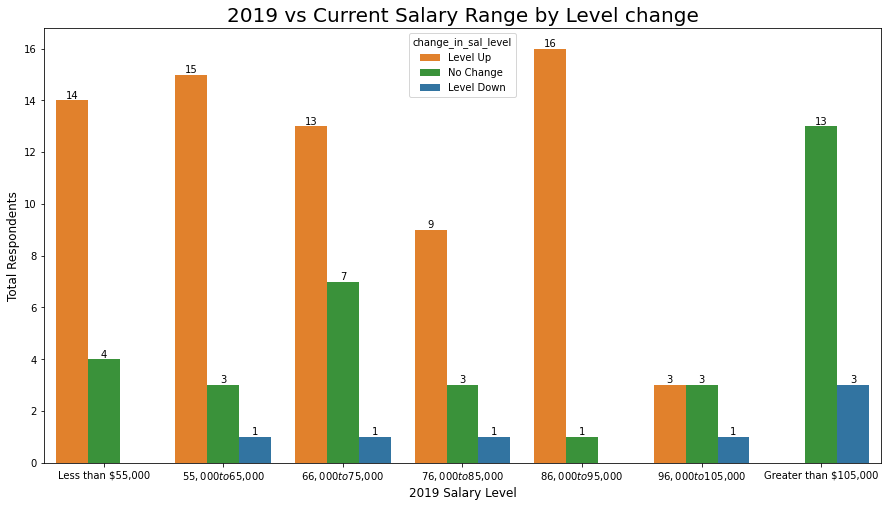

In [107]:
# annual_range_as_of_2019
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="annual_range_as_of_2019", hue="change_in_sal_level", hue_order=["Level Up", "No Change", "Level Down"], palette=palette1,
                   order=["Less than $55,000", "$55,000 to $65,000", "$66,000 to $75,000", "$76,000 to $85,000", "$86,000 to $95,000", "$96,000 to $105,000", "Greater than $105,000"])
for container in ax.containers:
    ax.bar_label(container)
plt.title( "2019 vs Current Salary Range by Level change", size = 20 )
plt.xlabel( "2019 Salary Level" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("10.jpg")
plt.show()

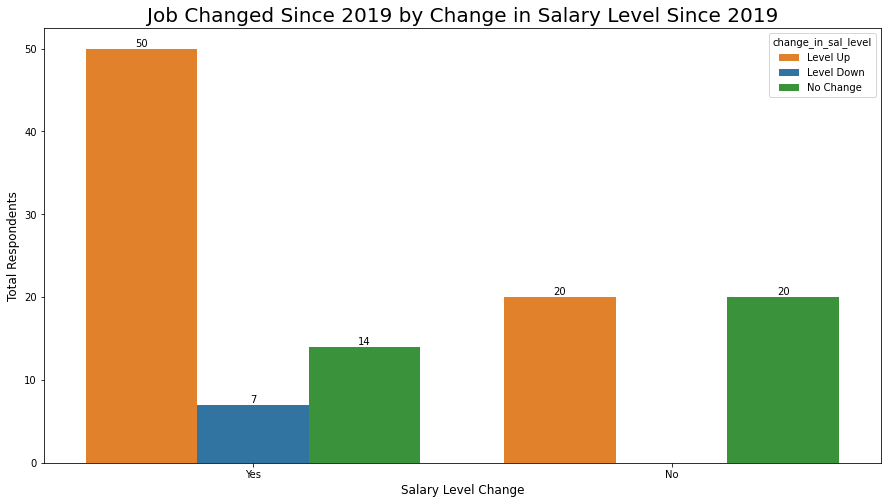

In [104]:
#change_in_sal_level vs job change
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="is_job_change_since_2019", hue="change_in_sal_level", order=["Yes", "No"],
              hue_order=["Level Up", "Level Down", "No Change"], palette=palette1)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019 by Change in Salary Level Since 2019", size = 20 )
plt.xlabel( "Salary Level Change" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("11.jpg")
plt.show()

***Unit Change Status***

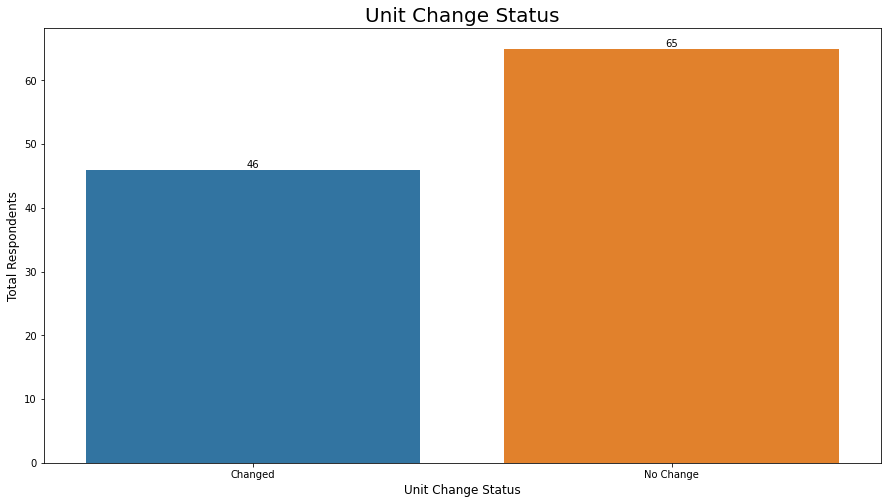

In [54]:
# unit change status
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="unit_change")
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Unit Change Status", size = 20 )
plt.xlabel( "Unit Change Status" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("12.jpg")
plt.show()

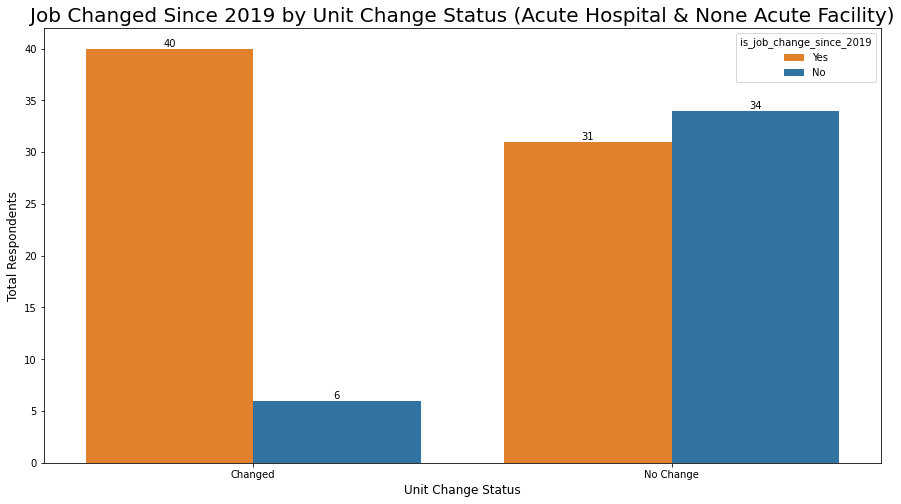

In [55]:
#unit_change vs job change
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="unit_change", hue="is_job_change_since_2019", order=["Changed", "No Change"],
              hue_order=["Yes", "No"], palette=palette)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019 by Unit Change Status (Acute Hospital & None Acute Facility)", size = 20 )
plt.xlabel( "Unit Change Status" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("13.jpg")
plt.show()

***Facility Type & Unit***

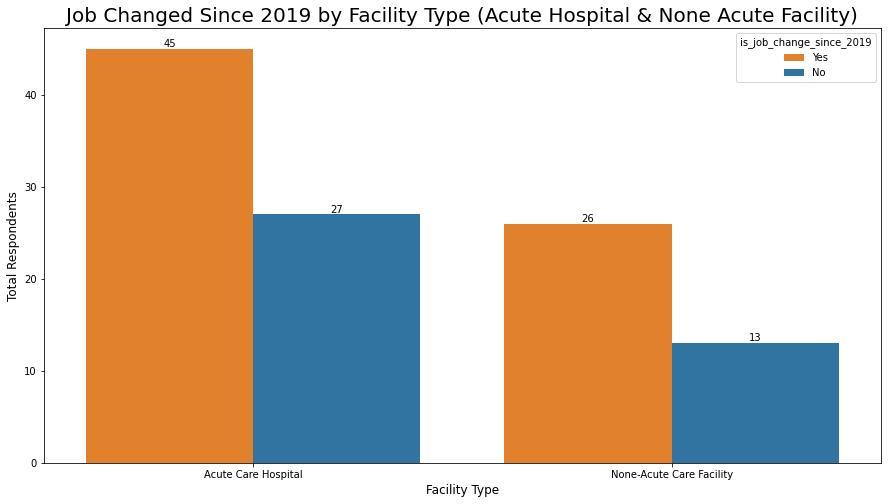

In [56]:
plt.figure(figsize = ( 15 , 8 ))
ax = sns.countplot(data=df, x="facility_2019", hue="is_job_change_since_2019", hue_order=["Yes", "No"], palette=palette)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019 by Facility Type (Acute Hospital & None Acute Facility)", size = 20 )
plt.xlabel( "Facility Type" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("14.jpg")
plt.show()

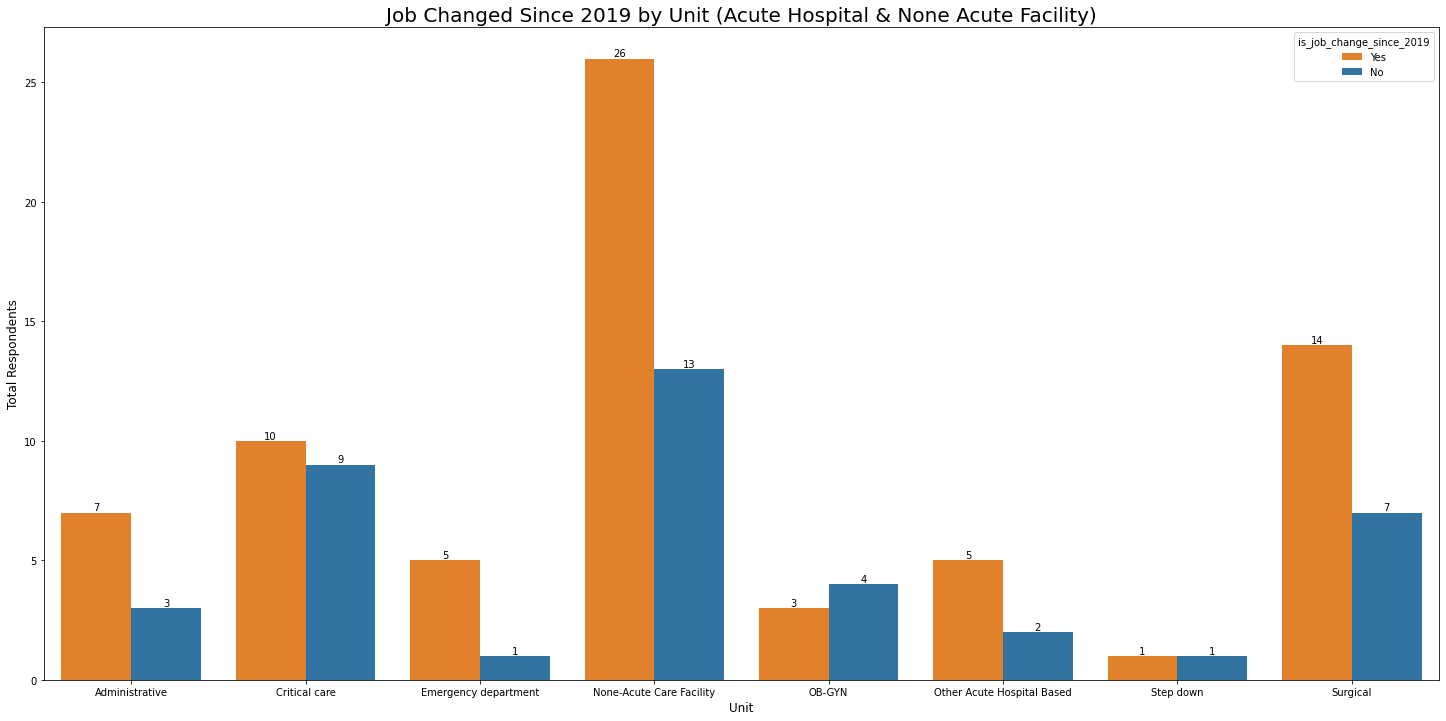

In [57]:
plt.figure(figsize = ( 25 , 12 ))
ax = sns.countplot(data=df, x="unit_2019", hue="is_job_change_since_2019", hue_order=["Yes", "No"], palette=palette)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "Job Changed Since 2019 by Unit (Acute Hospital & None Acute Facility)", size = 20 )
plt.xlabel( "Unit" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("15.jpg")
plt.show()

### 3.2.2 Where Did the Nurses go?

#### 1. OVERALL

***2019 Unit vs Current Unit***

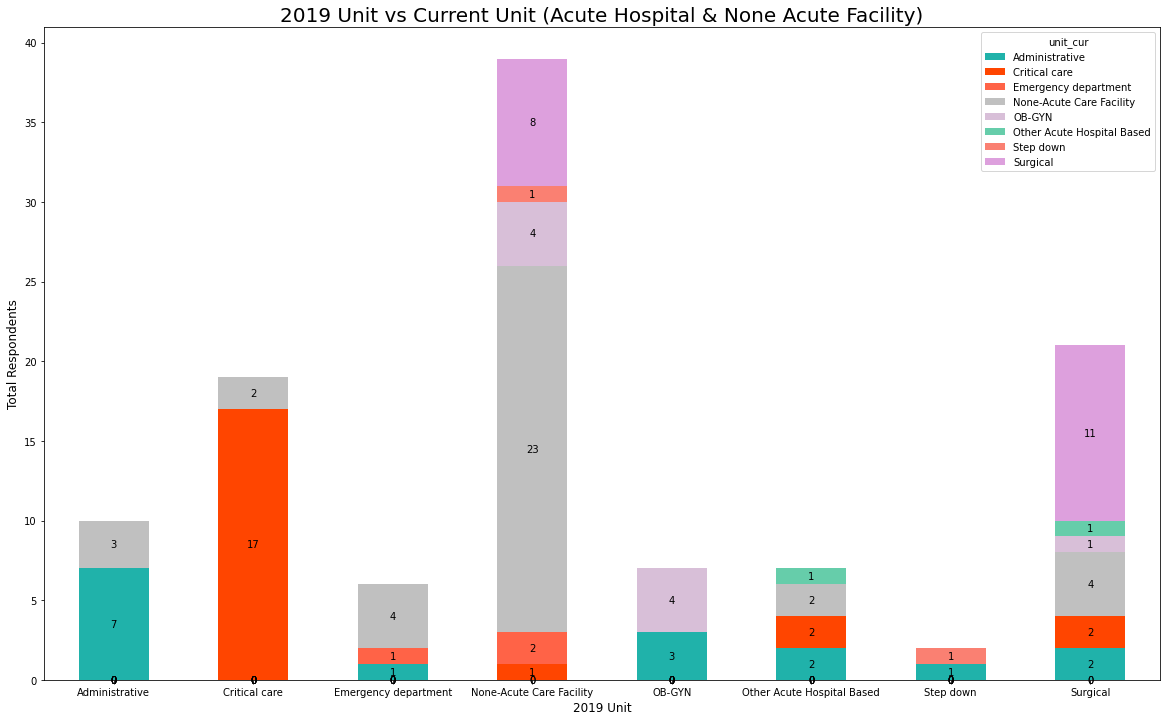

unit_cur,Administrative,Critical care,Emergency department,None-Acute Care Facility,OB-GYN,Other Acute Hospital Based,Step down,Surgical
unit_2019,,,,,,,,
Administrative,7,0,0,3,0,0,0,0
Critical care,0,17,0,2,0,0,0,0
Emergency department,1,0,1,4,0,0,0,0
None-Acute Care Facility,0,1,2,23,4,0,1,8
OB-GYN,3,0,0,0,4,0,0,0
Other Acute Hospital Based,2,2,0,2,0,1,0,0
Step down,1,0,0,0,0,0,1,0
Surgical,2,2,0,4,1,1,0,11


In [58]:
#unit_2019 vs. unit_cur
unit_change_cnt = pd.crosstab(df["unit_2019"], df["unit_cur"])

colors = ["lightseagreen", "orangered", "tomato", "silver", "thistle", "mediumaquamarine", "salmon", "plum"]
ax = unit_change_cnt.plot(kind="bar", stacked=True, rot=0, color=colors, figsize=(20,12))
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.title( "2019 Unit vs Current Unit (Acute Hospital & None Acute Facility)", size = 20 )
plt.xlabel( "2019 Unit" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("16.jpg")
plt.show()
unit_change_cnt

#### 2. JOB CHANGED

***Job Changed - 2019 vs Current Facility Type***

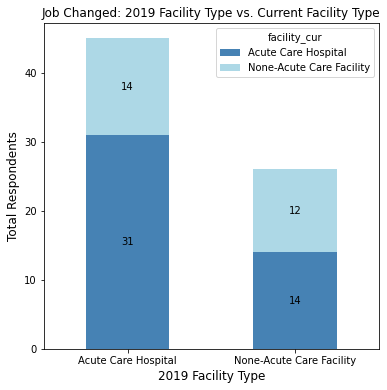

facility_cur,Acute Care Hospital,None-Acute Care Facility
facility_2019,,
Acute Care Hospital,31,14
None-Acute Care Facility,14,12


In [59]:
jc = df[df["is_job_change_since_2019"]=="Yes"].reset_index()
jc_fct = pd.crosstab(jc["facility_2019"], jc["facility_cur"])

colors = ["steelblue", "lightblue"]
ax = jc_fct.plot(kind="bar", stacked=True, rot=0, color=colors, figsize=(6,6))
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.title( "Job Changed: 2019 Facility Type vs. Current Facility Type", size = 12 )
plt.xlabel( "2019 Facility Type" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("17.jpg")
plt.show()
jc_fct

***Job Changed - 2019 vs Current Unit Type***

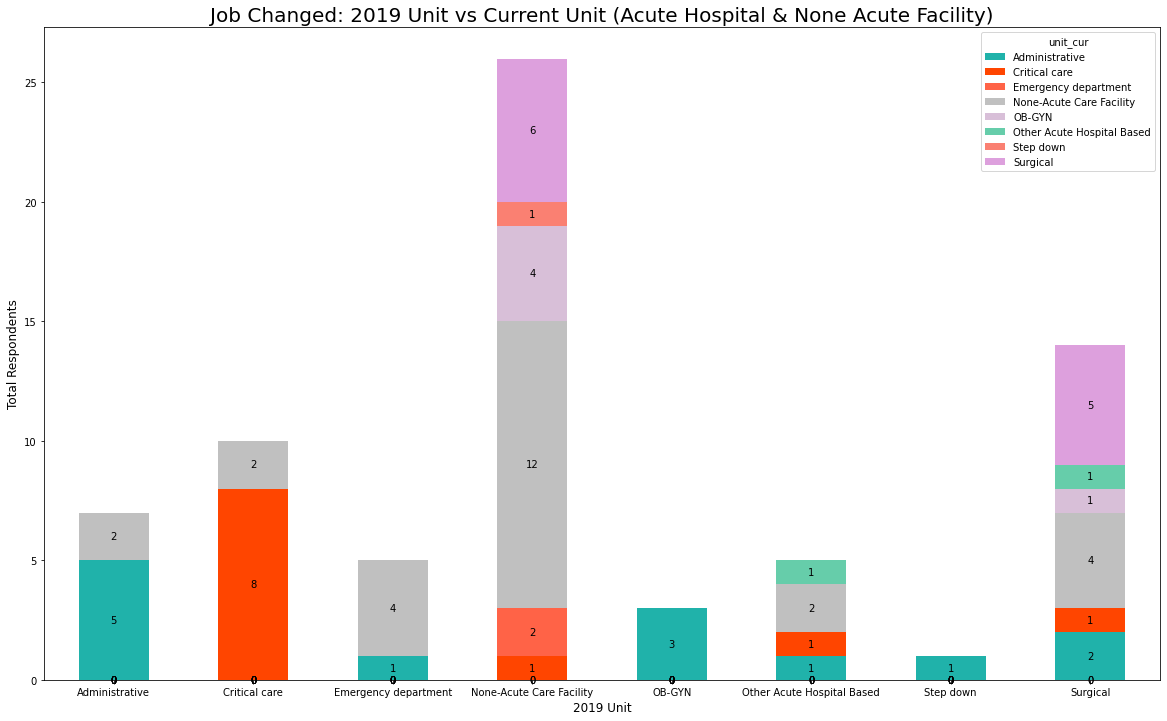

unit_cur,Administrative,Critical care,Emergency department,None-Acute Care Facility,OB-GYN,Other Acute Hospital Based,Step down,Surgical
unit_2019,,,,,,,,
Administrative,5,0,0,2,0,0,0,0
Critical care,0,8,0,2,0,0,0,0
Emergency department,1,0,0,4,0,0,0,0
None-Acute Care Facility,0,1,2,12,4,0,1,6
OB-GYN,3,0,0,0,0,0,0,0
Other Acute Hospital Based,1,1,0,2,0,1,0,0
Step down,1,0,0,0,0,0,0,0
Surgical,2,1,0,4,1,1,0,5


In [60]:
jc_uct = pd.crosstab(jc["unit_2019"], jc["unit_cur"])

colors = ["lightseagreen", "orangered", "tomato", "silver", "thistle", "mediumaquamarine", "salmon", "plum"]
ax = jc_uct.plot(kind="bar", stacked=True, rot=0, color=colors, figsize=(20,12))
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.title( "Job Changed: 2019 Unit vs Current Unit (Acute Hospital & None Acute Facility)", size = 20 )
plt.xlabel( "2019 Unit" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("18.jpg")
plt.show()
jc_uct

#### 3. JOB NO CHANGE

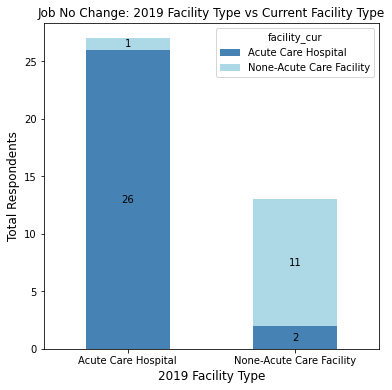

facility_cur,Acute Care Hospital,None-Acute Care Facility
facility_2019,,
Acute Care Hospital,26,1
None-Acute Care Facility,2,11


In [61]:
jnc = df[df["is_job_change_since_2019"]=="No"].reset_index()
jnc_fct = pd.crosstab(jnc["facility_2019"], jnc["facility_cur"])

colors = ["steelblue", "lightblue"]
ax = jnc_fct.plot(kind="bar", stacked=True, rot=0, color=colors, figsize=(6,6))
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.title( "Job No Change: 2019 Facility Type vs Current Facility Type", size = 12 )
plt.xlabel( "2019 Facility Type" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("19.jpg")
plt.show()
jnc_fct

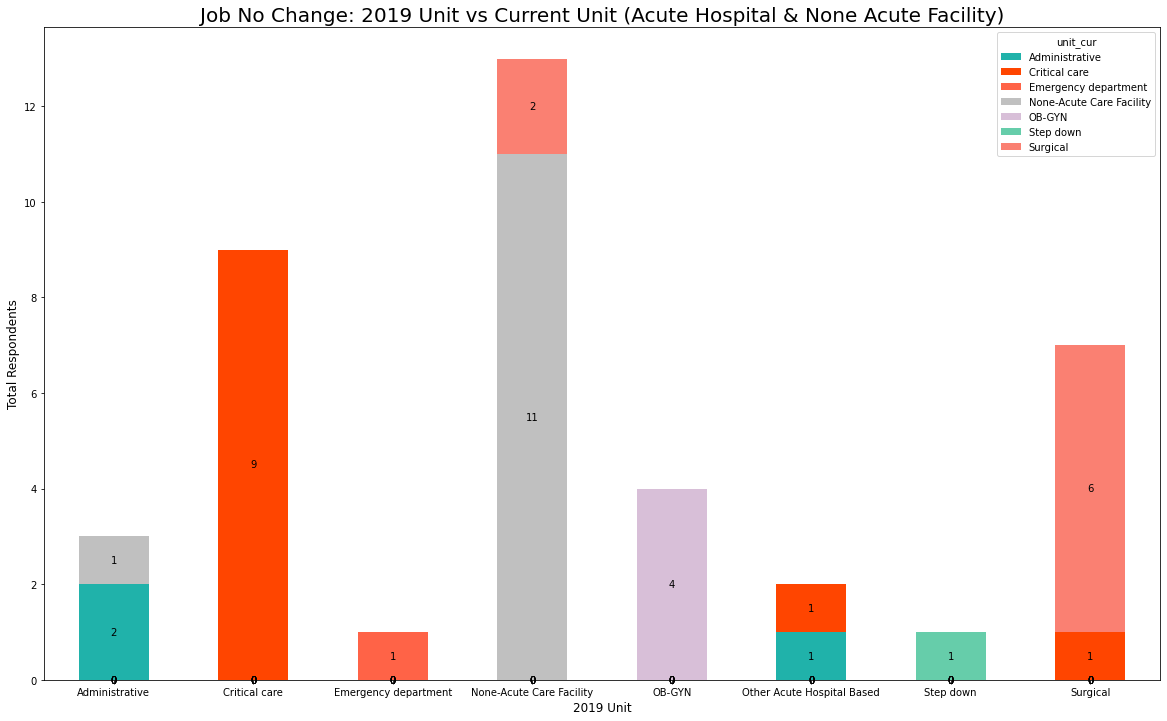

unit_cur,Administrative,Critical care,Emergency department,None-Acute Care Facility,OB-GYN,Step down,Surgical
unit_2019,,,,,,,
Administrative,2,0,0,1,0,0,0
Critical care,0,9,0,0,0,0,0
Emergency department,0,0,1,0,0,0,0
None-Acute Care Facility,0,0,0,11,0,0,2
OB-GYN,0,0,0,0,4,0,0
Other Acute Hospital Based,1,1,0,0,0,0,0
Step down,0,0,0,0,0,1,0
Surgical,0,1,0,0,0,0,6


In [62]:
jnc_uct = pd.crosstab(jnc["unit_2019"], jnc["unit_cur"])

colors = ["lightseagreen", "orangered", "tomato", "silver", "thistle", "mediumaquamarine", "salmon", "plum"]
ax = jnc_uct.plot(kind="bar", stacked=True, rot=0, color=colors, figsize=(20,12))
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.title( "Job No Change: 2019 Unit vs Current Unit (Acute Hospital & None Acute Facility)", size = 20 )
plt.xlabel( "2019 Unit" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
#plt.savefig("20.jpg")
plt.show()
jnc_uct

## 3.3 Association Analysis

#### 3.3.1 CHI-SQUARE: ***Test Independence***
- H0: the variables are independent, there is no relationship between the two categorical variables. Knowing the value of one variable does not help to predict the value of the other variable.
- H1: the variables are dependent, there is a relationship between the two categorical variables. Knowing the value of one variable helps to predict the value of the other variable.

**Test Variables:**
1. age_group ***vs.*** is_job_change_since_2019
2. highest_education ***vs.*** is_job_change_since_2019
3. gender ***vs.*** is_job_change_since_2019
4. cur_license_state_group ***vs.*** is_job_change_since_2019
5. license_type_change_since2019 ***vs.*** is_job_change_since_2019 
6. years_in_profession_cat ***vs.*** is_job_change_since_2019
7. change_in_sal_level ***vs.*** is_job_change_since_2019
8. unit_change ***vs.*** is_job_change_since_2019
9. unit_2019 ***vs.*** unit_cur

In [63]:
# get test variables
test_col = ["age_group", "highest_education", "gender", "cur_license_state_group", "license_type_change_since2019", 
            "years_in_profession_cat", "change_in_sal_level", "unit_change", "unit_2019", "unit_cur", "is_job_change_since_2019"]
other_col = [c for c in df.columns if c not in test_col]

df_test = df.drop(other_col, axis=1)

In [65]:
# create col & col combo
chi_var1 = df_test.columns
chi_var2 = df_test.columns
chi_var_prod = list(product(chi_var1,chi_var2, repeat = 1))
chi_var_prod

[('age_group', 'age_group'),
 ('age_group', 'gender'),
 ('age_group', 'highest_education'),
 ('age_group', 'is_job_change_since_2019'),
 ('age_group', 'cur_license_state_group'),
 ('age_group', 'license_type_change_since2019'),
 ('age_group', 'change_in_sal_level'),
 ('age_group', 'unit_2019'),
 ('age_group', 'unit_cur'),
 ('age_group', 'unit_change'),
 ('age_group', 'years_in_profession_cat'),
 ('gender', 'age_group'),
 ('gender', 'gender'),
 ('gender', 'highest_education'),
 ('gender', 'is_job_change_since_2019'),
 ('gender', 'cur_license_state_group'),
 ('gender', 'license_type_change_since2019'),
 ('gender', 'change_in_sal_level'),
 ('gender', 'unit_2019'),
 ('gender', 'unit_cur'),
 ('gender', 'unit_change'),
 ('gender', 'years_in_profession_cat'),
 ('highest_education', 'age_group'),
 ('highest_education', 'gender'),
 ('highest_education', 'highest_education'),
 ('highest_education', 'is_job_change_since_2019'),
 ('highest_education', 'cur_license_state_group'),
 ('highest_educati

In [66]:
# chi-square
chi_result = []
for i in chi_var_prod:
    if i[0] != i[1]:
        chi_result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(df_test[i[0]], df_test[i[1]])))[1])) 

In [67]:
chi_test_output = pd.DataFrame(chi_result, columns = ["var1", "var2", "coeff"])
## Using pivot function to convert the above DataFrame into a crosstab
chi_test_output.pivot(index="var1", columns="var2", values="coeff")

var2,age_group,change_in_sal_level,cur_license_state_group,gender,highest_education,is_job_change_since_2019,license_type_change_since2019,unit_2019,unit_change,unit_cur,years_in_profession_cat
var1,,,,,,,,,,,
age_group,NaN,0.449533,0.129465,0.658610,0.053409,0.139129,2.725033e-10,3.554257e-02,0.116691,3.136947e-01,3.550979e-21
change_in_sal_level,4.495329e-01,NaN,0.057195,0.322260,0.042627,0.001297,5.036494e-01,9.648065e-01,0.226397,4.762477e-01,2.433401e-01
cur_license_state_group,1.294647e-01,0.057195,NaN,0.366227,0.101941,0.240334,1.283921e-01,9.420830e-01,0.304384,9.063788e-01,1.309932e-01
gender,6.586101e-01,0.322260,0.366227,NaN,0.265982,0.942969,8.067296e-01,4.869139e-03,0.810736,1.431271e-01,3.478811e-02
highest_education,5.340891e-02,0.042627,0.101941,0.265982,NaN,0.333145,1.854399e-02,1.517736e-01,0.465758,8.478449e-02,2.739168e-02
is_job_change_since_2019,1.391286e-01,0.001297,0.240334,0.942969,0.333145,NaN,4.967062e-02,7.711353e-01,0.000053,5.225922e-01,1.888145e-02
license_type_change_since2019,2.725033e-10,0.503649,0.128392,0.806730,0.018544,0.049671,NaN,8.456144e-03,0.019943,3.235834e-02,1.820855e-11
unit_2019,3.554257e-02,0.964806,0.942083,0.004869,0.151774,0.771135,8.456144e-03,NaN,0.010234,8.617566e-21,2.582603e-03
unit_change,1.166906e-01,0.226397,0.304384,0.810736,0.465758,0.000053,1.994265e-02,1.023397e-02,NaN,5.016706e-01,9.662229e-03


In [68]:
# print variables that are dependent
for i in chi_result:
    if i[2] < 0.05: 
        sig_result = i
        print(sig_result)  

('age_group', 'license_type_change_since2019', 2.725032757505817e-10)
('age_group', 'unit_2019', 0.03554256903285003)
('age_group', 'years_in_profession_cat', 3.550979022279929e-21)
('gender', 'unit_2019', 0.004869138629560386)
('gender', 'years_in_profession_cat', 0.03478810994949307)
('highest_education', 'license_type_change_since2019', 0.018543991675147895)
('highest_education', 'change_in_sal_level', 0.04262685309808641)
('highest_education', 'years_in_profession_cat', 0.027391679110134577)
('is_job_change_since_2019', 'license_type_change_since2019', 0.04967061538416686)
('is_job_change_since_2019', 'change_in_sal_level', 0.0012970658427195966)
('is_job_change_since_2019', 'unit_change', 5.2564531254556887e-05)
('is_job_change_since_2019', 'years_in_profession_cat', 0.018881453479652633)
('license_type_change_since2019', 'age_group', 2.725032757505837e-10)
('license_type_change_since2019', 'highest_education', 0.018543991675147895)
('license_type_change_since2019', 'is_job_change

#### 3.3.2 CHI-SQUARE: ***Test Independence Conclusion***
1. **job change status since 2019 is_job_change_since_2019 ['Yes', 'No'] is associated with:**
    - license type changed since 2019 <br /> ['Healthcare to Nurse', 'Nurse License Changed', 'Nurse License the Same', 'None-Healthcare to Nurse']
    - change in salary level <br /> ['Level Up', 'Level Down', 'No Change']
    - unit change <br /> ['No Change', 'Changed']
    - years in profession level <br /> ['4-5 year', '16-20 year', '11-15 year', '21-30 year', '1-3 year', 'greater than 30 years', '6-10 year']
2. **unit change ['Changed', 'No Change'] is associated with:**
    - job change status since 2019 <br /> ['Yes', 'No'] 
    - license type changed since 2019' <br /> ['Healthcare to Nurse', 'Nurse License Changed', 'Nurse License the Same', 'None-Healthcare to Nurse']
    - change in salary level <br /> ['Level Up', 'Level Down', 'No Change']
    - years in profession level <br /> ['4-5 year', '16-20 year', '11-15 year', '21-30 year', '1-3 year', 'greater than 30 years', '6-10 year']
    - unit 2019 <br /> ['None-Acute Care Facility', 'Surgical', 'OB-GYN', 'Emergency department', 'Critical care', 'Other Acute Hospital Based', 'Administrative', 'Step down']
3. **2019 unit & current unit are assciated** <br /> ['None-Acute Care Facility', 'Surgical', 'OB-GYN', 'Emergency department', 'Critical care', 'Other Acute Hospital Based', 'Administrative', 'Step down'] 

## IV. Summary

Chi-Square test for independence was used for testing weather there's a relation between 2019 unit and current unit. Basiced on the reusult, p < 0.05, 2019 unit is associated with current unit, meaning there are patterns where nurses go from one unit to another (See 3.2.2 Where Did the Nurses go?). The result also shows that changes in license type, changes in salary and level of years in profession are associated with job change and unit change.

In [69]:
df.columns

Index(['age_group', 'gender', 'highest_education', 'len_of_cur_license_level',
       'annual_range_as_of_2019', 'cur_annual_range',
       'is_job_change_since_2019', 'cur_highest_license', 'cur_total_license',
       'cur_license_state_group', 'years_in_profession',
       'occupation_asof_2019', 'license_type_change_since2019',
       'change_in_sal_level', 'total_job_changed_since2019', 'facility_2019',
       'facility_cur', 'unit_2019', 'unit_cur', 'facility_change',
       'unit_change', 'facility_unit_2019', 'facility_unit_cur',
       'facility-unit_change', 'years_in_profession_cat',
       'years_in_profession_cat_num'],
      dtype='object')

## Association Rule

In [70]:
# get data set for association rule
asdf = df[["total_job_changed_since2019", "is_job_change_since_2019", "unit_change", "unit_2019", "unit_cur", "change_in_sal_level"]]
# change current facility name by apppeding number 1 to the end where nurses haven't changed jobs nor unit since 2019
asdf["unit_cur"] = np.where( (asdf["is_job_change_since_2019"]=="No") & (asdf["unit_change"]=="No Change"), np.nan, asdf["unit_cur"].astype(str)+" 1" ) 
asdf["unit_cur"].unique()

<ipython-input-70-359410bb4917>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asdf["unit_cur"] = np.where( (asdf["is_job_change_since_2019"]=="No") & (asdf["unit_change"]=="No Change"), np.nan, asdf["unit_cur"].astype(str)+" 1" )


array(['None-Acute Care Facility 1', 'Surgical 1', 'OB-GYN 1', nan,
       'Emergency department 1', 'Administrative 1', 'Critical care 1',
       'Other Acute Hospital Based 1', 'Step down 1'], dtype=object)

In [71]:
asdf["unit_cur"].value_counts()

None-Acute Care Facility 1      27
Administrative 1                14
Surgical 1                      13
Critical care 1                 13
OB-GYN 1                         5
Other Acute Hospital Based 1     2
Emergency department 1           2
Step down 1                      1
Name: unit_cur, dtype: int64

In [81]:
ardf = asdf[["unit_2019", "unit_cur", "change_in_sal_level"]]
ardf

,unit_2019,unit_cur,change_in_sal_level
0,None-Acute Care Facility,None-Acute Care Facility 1,Level Up
1,None-Acute Care Facility,Surgical 1,Level Up
2,None-Acute Care Facility,None-Acute Care Facility 1,Level Down
3,Surgical,OB-GYN 1,Level Up
4,None-Acute Care Facility,None-Acute Care Facility 1,Level Up
...,...,...,...
108,Surgical,NaN,No Change
109,Surgical,NaN,No Change
110,Surgical,Critical care 1,No Change
111,None-Acute Care Facility,NaN,No Change


In [108]:
transactions = []
for i in range(0, ardf.shape[0]):
    transactions.append([str(ardf.values[i, j]) for j in range(0, 2)])

print(transactions[0])

['None-Acute Care Facility', 'None-Acute Care Facility 1']


In [109]:
from apyori import apriori

In [110]:
rules = apriori(transactions, min_support = 0.003, min_confidence = 0.2, min_lift = 3, min_length = 2)
results = list(rules)

In [111]:
#results = pd.DataFrame(results)
#results

In [112]:
for item in results:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: Administrative -> Administrative 1
Support: 0.04504504504504504
Confidence: 0.5
Lift: 3.964285714285715
Rule: OB-GYN -> Administrative 1
Support: 0.02702702702702703
Confidence: 0.21428571428571433
Lift: 3.3979591836734704
Rule: Administrative 1 -> Step down
Support: 0.009009009009009009
Confidence: 0.5
Lift: 3.964285714285715
Rule: Critical care -> Critical care 1
Support: 0.07207207207207207
Confidence: 0.42105263157894735
Lift: 3.595141700404858
Rule: Other Acute Hospital Based 1 -> Other Acute Hospital Based
Support: 0.009009009009009009
Confidence: 0.5
Lift: 7.92857142857143


In [160]:
for item in association_rules:
    print(item)

In [159]:
for item in association_rules:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

In [88]:
df.columns

Index(['age_group', 'gender', 'highest_education', 'len_of_cur_license_level',
       'annual_range_as_of_2019', 'cur_annual_range',
       'is_job_change_since_2019', 'cur_highest_license', 'cur_total_license',
       'cur_license_state_group', 'years_in_profession',
       'occupation_asof_2019', 'license_type_change_since2019',
       'change_in_sal_level', 'total_job_changed_since2019', 'facility_2019',
       'facility_cur', 'unit_2019', 'unit_cur', 'facility_change',
       'unit_change', 'facility_unit_2019', 'facility_unit_cur',
       'facility-unit_change', 'years_in_profession_cat',
       'years_in_profession_cat_num'],
      dtype='object')

In [92]:
df[["annual_range_as_of_2019", "unit_2019", "cur_annual_range", "unit_cur", "change_in_sal_level"]][df["change_in_sal_level"]=="Level Up"]

,annual_range_as_of_2019,unit_2019,cur_annual_range,unit_cur,change_in_sal_level
0,"Less than $55,000",None-Acute Care Facility,"$86,000 to $95,000",None-Acute Care Facility,Level Up
1,"Less than $55,000",None-Acute Care Facility,"$76,000 to $85,000",Surgical,Level Up
3,"Less than $55,000",Surgical,"$55,000 to $65,000",OB-GYN,Level Up
4,"$55,000 to $65,000",None-Acute Care Facility,"$86,000 to $95,000",None-Acute Care Facility,Level Up
5,"$55,000 to $65,000",None-Acute Care Facility,"$76,000 to $85,000",None-Acute Care Facility,Level Up
...,...,...,...,...,...
100,"$55,000 to $65,000",Critical care,"$66,000 to $75,000",Critical care,Level Up
101,"$55,000 to $65,000",Critical care,"$96,000 to $105,000",Critical care,Level Up
102,"$76,000 to $85,000",Administrative,"$96,000 to $105,000",None-Acute Care Facility,Level Up
105,"$66,000 to $75,000",Critical care,"$96,000 to $105,000",Critical care,Level Up


In [80]:
# verify source: is job changed = no -> total job changed
#                is job changed = yes -> total job changed
df[df["is_job_change_since_2019"]=="No"]["total_job_changed_since2019"].unique()
df[df["is_job_change_since_2019"]=="Yes"]["total_job_changed_since2019"].unique()

array([2, 4, 3, 1])

In [92]:
df[df["is_job_change_since_2019"]=="No"]["unit_change"].unique()
#df[df["is_job_change_since_2019"]=="Yes"]["unit_change"].unique()

['No Change', 'Changed']
Categories (2, object): ['No Change', 'Changed']

In [ ]:
pd.crosstab(asdf["is_job_change_since_2019"], asdf["unit_change"])